# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import datasets
from copy import copy, deepcopy
import copy

# imports from other HWs
import nbimporter

from hw01 import train_test_split

Importing Jupyter notebook from hw01.ipynb


### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [2]:
def append_one_to_X(X):
    newX = np.ones((X.shape[0], X.shape[1] + 1))
    newX[:,1:] = X
    return newX

class Perceptron:
    def __init__(self, iterations=100):
        self.iterations = iterations
    
    def fit(self, X, Y):
        newX = append_one_to_X(X)
        self.w = np.zeros((newX.shape[1], 1))
        for _ in range(self.iterations):
            self._one_fit_iteration(newX, Y)
                    
    def _one_fit_iteration(self, newX, Y):
        for x, y_true in zip(newX, Y):
            y_pred = x @ self.w > 0
            if y_pred != y_true:
                self.w += x.reshape(-1, 1) * (2 * y_true - 1)
                    
    def predict(self, X):
        newX = append_one_to_X(X)
        return 1 - np.array(newX @ self.w < 0, dtype=int).reshape(X.shape[0])

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

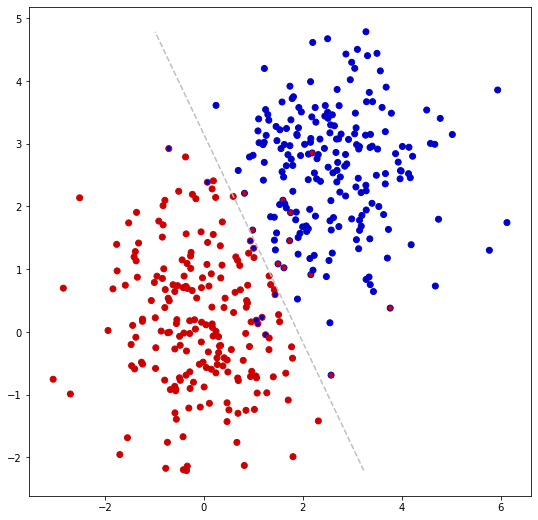

In [5]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

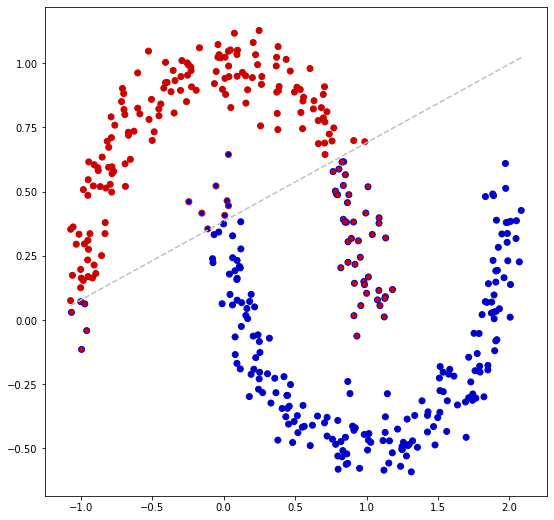

In [6]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. 
Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [8]:
class PerceptronBest:
    def __init__(self, iterations=100):
        self.iterations = iterations
        self.best_perceptron = None
    
    def fit(self, X, Y):
        newX = append_one_to_X(X)
        perceptron = Perceptron()
        perceptron.w = np.zeros((newX.shape[1], 1))
        
        min_errors = float("+inf")
        for _ in range(self.iterations):
            perceptron._one_fit_iteration(newX, Y)
            errors = np.sum(perceptron.predict(X) == Y)
            if errors < min_errors:
                min_errors = errors
                self.best_perceptron = deepcopy(perceptron)
            
    def predict(self, X):
        return self.best_perceptron.predict(X)

In [3]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

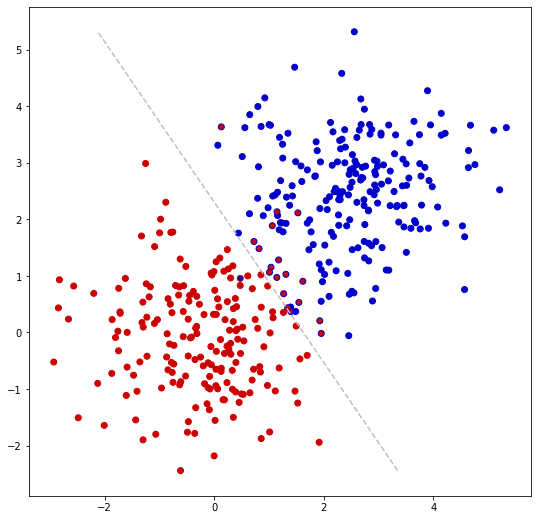

In [9]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.best_perceptron.w)

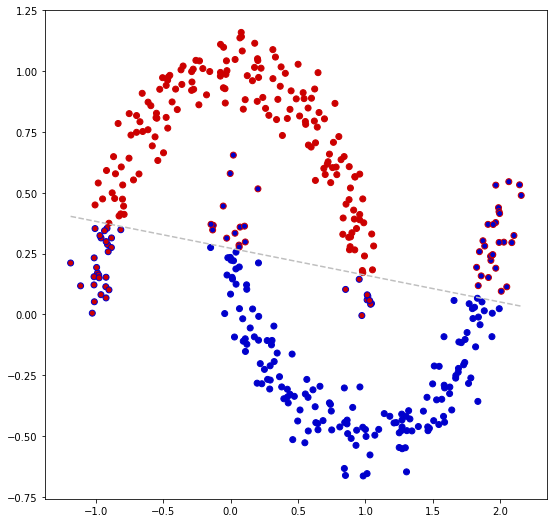

In [10]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.best_perceptron.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [12]:
pca = PCA(n_components=2)

def transform_images(images):
    return pca.fit_transform(images.reshape(len(images), -1))

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [13]:
X, y = get_digits()
y = (y - 1) / 4 # make labels \in {0, 1}

X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)

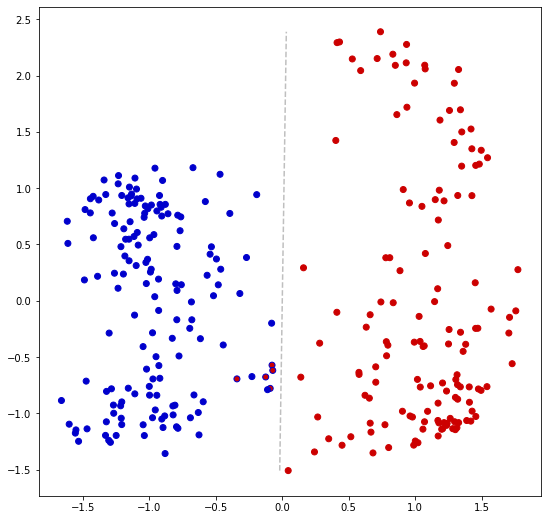

Accuracy: 0.9726027397260274


In [14]:
c = Perceptron()
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

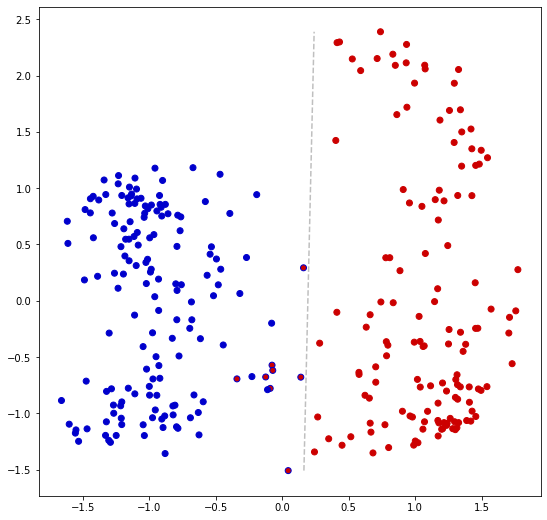

Accuracy: 0.958904109589041


In [16]:
c = PerceptronBest()
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.best_perceptron.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [21]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0 + 1, 10)]:
    X, y = get_digits(y0, y1)
    y = (y - min(y)) / (max(y) - min(y))
    X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)
    c = Perceptron()
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.9668990162861151


In [22]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0 + 1, 10)]:
    X, y = get_digits(y0, y1)
    y = (y - min(y)) / (max(y) - min(y))
    X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)
    c = PerceptronBest()
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.9451971221885686
